# Doublets 😎

In [1]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la

la.logger.setLevel("INFO")

## Model 1

In [2]:
n_cells = 50
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim("C" + pd.Series(cell_ids, name="cell"))

n_genes = 100
genes = la.Dim("G" + pd.Series([str(i) for i in range(n_genes)]), name="gene")

celltype_ids = "Ct" + pd.Series(["a", "b"])
celltypes = la.Dim(celltype_ids, name = "celltype")

In [3]:
# celltype_value = pd.Series(np.random.choice(["a", "b"], n_cells, replace = True), index = cells.index)

In [4]:
baseline_expression_value = pd.DataFrame(np.random.normal(scale = 3, size = (celltypes.size, genes.size)), index = celltypes.index, columns = genes.index)

In [5]:
proportions_value = pd.DataFrame(np.random.dirichlet((3., 5), size = (cells.size)), index = cells.index, columns = celltypes.index)

<AxesSubplot:xlabel='celltype', ylabel='cell'>

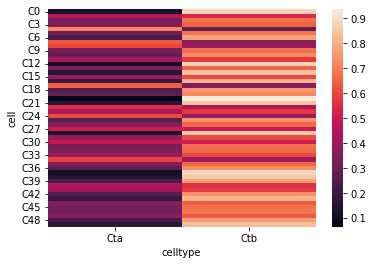

In [6]:
# proportions_value = np.exp(proportions_value)/np.exp(proportions_value).sum(1).values[:, None]
sns.heatmap(proportions_value)

In [7]:
proportions = la.Fixed(proportions_value, label = "proportions")

In [8]:
expression = la.links.vector.Matmul(proportions, baseline_expression_value, output = la.Definition([cells, genes]), label = "expression")

In [9]:
expression.plot()

In [10]:
noise = la.Fixed(1.)

In [11]:
dist = la.distributions.Normal(expression, noise, label = "dist")

In [12]:
dist.plot()

In [13]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

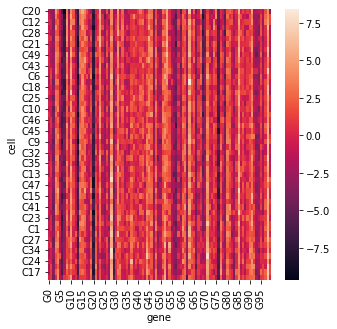

In [14]:
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
fig, (ax0) = plt.subplots(1, 1, figsize=(5, 5))
cell_order = proportions_value[celltype_ids[0]].sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Cta', ylabel='G4'>

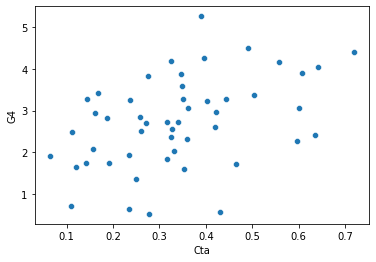

In [15]:
sns.scatterplot(proportions_value.loc[cell_order, celltype_ids[0]], observation_value.loc[cell_order]["G4"])

## Model 2

In [16]:
n_cells = 50
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim("C" + pd.Series(cell_ids, name="cell"))

n_genes = 100
genes = la.Dim("G" + pd.Series([str(i) for i in range(n_genes)]), name="gene")

celltype_ids = "Ct" + pd.Series(["a", "b"])
celltypes = la.Dim(celltype_ids, name = "celltype")

In [17]:
baseline_expression_value = pd.DataFrame(np.random.normal(scale = 3, size = (celltypes.size, genes.size)), index = celltypes.index, columns = genes.index)
baseline_expression = la.Fixed(baseline_expression_value, label = "baseline")

In [18]:
baseline_modifier_value = (np.random.random(baseline_expression.shape) > 0.5) * (np.random.choice([-1, 1], baseline_expression.shape)) * (np.random.normal(3.0, 1.0, baseline_expression.shape))
baseline_modifier = la.Fixed(baseline_modifier_value, definition = baseline_expression)

In [19]:
responded_baseline_expression = la.links.scalar.Linear(baseline_expression, b = baseline_modifier)

In [20]:
proportions_value = pd.DataFrame(np.random.dirichlet((3., 5), size = (cells.size)), index = cells.index, columns = celltypes.index)

In [21]:
proportions = la.Fixed(proportions_value, label = "proportions")

In [22]:
# expression = la.links.vector.Matmul(proportions, baseline_expression, output = la.Definition([cells, genes]), label = "expression")
expression = la.links.vector.Matmul(proportions, responded_baseline_expression, output = la.Definition([cells, genes]), label = "expression")

In [23]:
expression.plot()

In [24]:
noise = la.Fixed(0.1)

In [25]:
dist = la.distributions.Normal(expression, noise, label = "dist")

In [26]:
dist.plot()

In [27]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

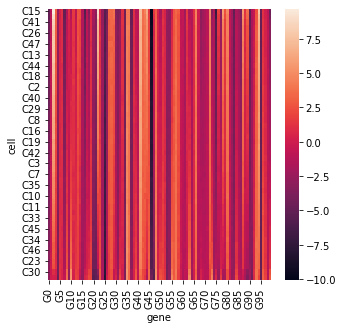

In [28]:
observation_value = posterior.samples[dist].sel(sample=0).to_pandas()
fig, (ax0) = plt.subplots(1, 1, figsize=(5, 5))
cell_order = proportions_value[celltype_ids[0]].sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax=ax0)

G0
celltype
Cta    0.000000
Ctb   -2.894652
Name: G0, dtype: float32
G1
celltype
Cta    3.28817
Ctb    0.00000
Name: G1, dtype: float32
G2
celltype
Cta    0.00000
Ctb    3.92093
Name: G2, dtype: float32
G3
celltype
Cta    0.0
Ctb    0.0
Name: G3, dtype: float32
G4
celltype
Cta   -4.427698
Ctb    0.000000
Name: G4, dtype: float32


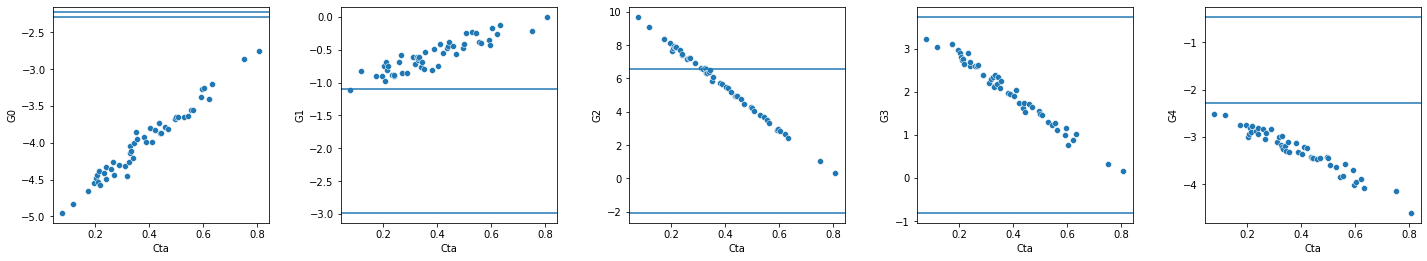

In [29]:
gene_ids_oi = genes.coords[:5]

fig, axes = la.plotting.axes_wrap(len(gene_ids_oi))

for gene_id, ax in zip(gene_ids_oi, axes):
    print(gene_id, )
    print(baseline_modifier.prior_pd()[gene_id])
    sns.scatterplot(
        x = proportions_value.loc[cell_order, celltype_ids[0]],
        y = observation_value.loc[cell_order][gene_id],
        ax = ax
    )
    for celltype in celltype_ids:
        ax.axhline(baseline_expression_value.loc[celltype, gene_id])